In [1]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



2024-12-19 15:53:26.030430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2024-12-19 15:53:26.030787: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2024-12-19 15:53:26.031132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2024-12-19 15:53:26.031701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cufft64_10.dll'; dlerror: cufft64_10.dll not found
2024-12-19 15:53:26.032120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'curand64_10.dll'; dlerror: curand64_10.dll not found
2024-12-19 15:53:26.032517: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

[]
Num GPUs Available:  0


In [3]:
# Configurar para usar solo la memoria necesaria
# physical_devices = tf.config.list_physical_devices('GPU')
# if physical_devices:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
#     print('done')

In [4]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [5]:
P0_exp=df2.iloc[:, -5:]
P1_exp=df2.iloc[:, 3:9]
P2_exp=df2.iloc[:, 9:14]
P3_exp=df2.iloc[:, [15,19,20]]


P0_exp, P1_exp, P2_exp, P3_exp


(0        H7      H8      H9     H10     H11
 0    0.0921   0.092   0.093  0.0927   0.093
 1    0.0921  0.0921  0.0931  0.0932  0.0925
 2    0.0922  0.0923  0.0932  0.0932  0.0927
 3    0.0928  0.0926  0.0936  0.0937   0.093
 4    0.0933  0.0933  0.0943  0.0944  0.0938
 ..      ...     ...     ...     ...     ...
 337  1.0018  0.9769  0.9848  0.9871  0.9972
 338  1.0017    0.98  0.9857  0.9868  0.9976
 339  1.0009  0.9758  0.9833  0.9846  0.9963
 340  1.0004  0.9763  0.9843  0.9845  0.9981
 341  1.0014  0.9772  0.9853  0.9843  0.9956
 
 [342 rows x 5 columns],
 0        A1      A2      A3      A4      A5      A6
 0    0.0929  0.0971  0.0948  0.0961  0.0939  0.0934
 1    0.0925  0.0962  0.0946  0.0953  0.0935  0.0931
 2    0.0926  0.0962   0.095  0.0954  0.0936  0.0932
 3    0.0928  0.0981  0.0949  0.0956  0.0937  0.0934
 4    0.0933  0.0985  0.0953   0.096  0.0942  0.0939
 ..      ...     ...     ...     ...     ...     ...
 337  0.5954  0.6453  0.6513  0.6593  0.6599  0.6576
 338  0.5

In [6]:
P2_exp.shape

(342, 5)

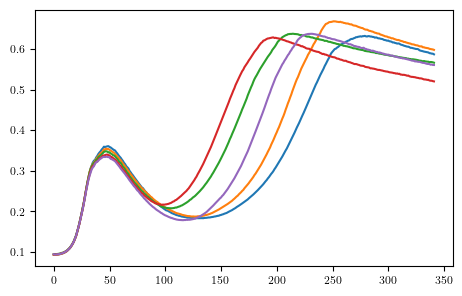

In [7]:
plt.plot(P2_exp)

In [8]:
P1_exp.shape

(342, 6)

In [9]:
c=-1
P_exp=np.hstack((P0_exp,P1_exp,P2_exp,P3_exp))
T_exp=np.array(df2['Time [s]'])

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
n=np.array([P0_exp.shape[1],P1_exp.shape[1],P2_exp.shape[1],P3_exp.shape[1],])
A=np.array([0, 1.25, 2.50, 3.75])
A=A/np.max(A)
N_exp,T_max, T_exp.shape, P_exp.shape, 342*23

(19, 231399.5, (342,), (342, 19), 7866)

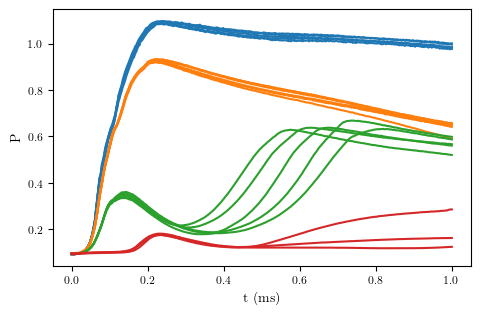

In [10]:
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)

plt.xlabel('t (ms)')
plt.ylabel('P')
plt.show()

In [11]:
N_f = 1000 # Number of residual point
N_d = 1500 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
Xa_star=[]
P0_star=np.empty((0, 1))
X_star = np.empty((0, 3))
for i in range(len(A)):
    P0=P_exp[0:1, np.sum(n[:i]):np.sum(n[:i+1])]
    P0_star=np.concatenate((P0_star,P0.T))
    T_meshgrid, P0_meshgrid, A_meshgrid = np.meshgrid(T_exp, P0, A[i])
    x=np.hstack((T_meshgrid.flatten()[:,None], P0_meshgrid.flatten()[:,None], A_meshgrid.flatten()[:,None]))
    Xa_star += [x]
    X_star=np.vstack((X_star,x))


u_star=np.hstack((P_star,X_star[:,1:2]))

In [12]:
# T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = X_star.min(0)
lb[1]=lb[1]
ub = X_star.max(0) 
ub[1]=ub[1]


# Initial Condition
xx0 = X_star[::len(T_exp)]
uu0 = P_star[::len(T_exp)]

xx1= np.hstack((np.ones(len(P0_star)).reshape([-1,1]), P0_star.reshape([-1,1]), xx0[...,2:3]))

xx01=np.vstack((xx0, xx1))
uu01=np.array([1]*N_exp+[0]*N_exp).reshape([-1,1])

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu0), replace=False)
xxd = X_star[idx]
uud = P_star[idx]

X_u_train = np.concatenate((xx0,xxd))
P_train = np.concatenate((uu0,uud))

X_f_train = lb + (ub-lb)*lhs(3, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
P_train_tf =   tf.convert_to_tensor(P_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)
xx01_tf = tf.convert_to_tensor(xx01, dtype=tf.float32)
uu01_tf = tf.convert_to_tensor(uu01, dtype=tf.float32)

2024-12-19 15:53:27.200538: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


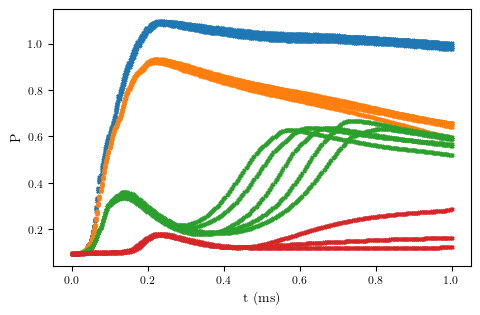

In [13]:
L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],P_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=5,  color=color)


plt.xlabel('t (ms)')
plt.ylabel('P')
plt.show()

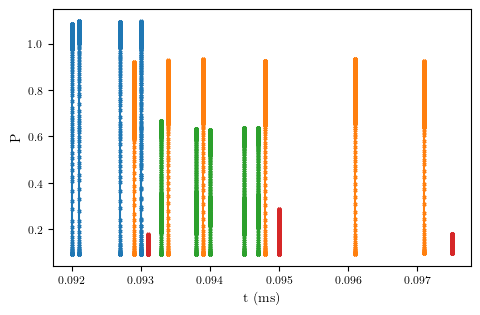

In [14]:
L_exp=len(P_exp[:,1])
for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        plt.plot(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,1],P_exp[:, (i + np.sum(n[:k]))], color=color)
        plt.scatter(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,1],P_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', color=color, s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

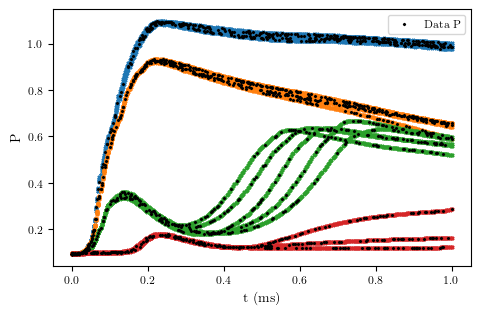

In [15]:
L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],P_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=5,  color=color)


plt.xlabel('t (ms)')
plt.ylabel('P')

plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

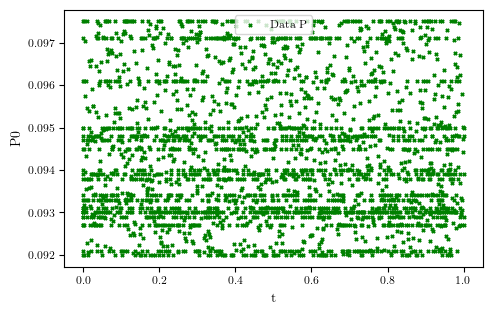

In [16]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,1], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
plt.ylabel('P0')
# plt.savefig('figures/P_phi.pdf')
plt.show()

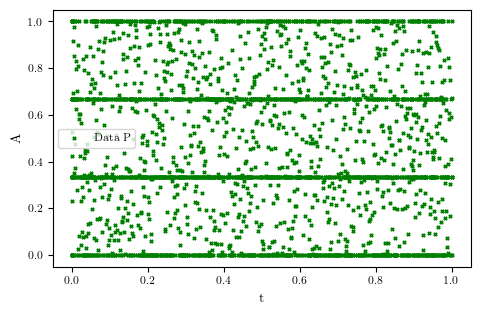

In [17]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,2], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
plt.ylabel('A')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [18]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    # A = 2.0*(X - lb)/(ub - lb) - 1.0
    A=X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 


def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r+N_b, 2]), dtype=tf.float32)
    alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp*2), (N_exp*2, -1))) 
    return alpha_r, alpha_b, alpha_0


#@tf.function(jit_compile=True)
@tf.function()
def net_f(X_f, W_p, b_p, W_phi, b_phi):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([X_f])
        u=net(X_f, W_p, b_p)

        lnp=u[:,0:1]
        lns=u[:,1:2]

        p=tf.exp(lnp)
        s=tf.exp(lns)
        # m=tf.exp(lnv[0:1])
        a=X_f[...,2:3]
        # phi_s=tf.exp(net(a, W_a, b_a))
        
        phi=net(tf.concat([p, s, a],1), W_phi, b_phi)
        # phi=tf.exp(net(s, W_phi, b_phi))



    p_t = tape1.gradient(p, X_f)[...,0:1]
    s_t = tape1.gradient(s, X_f)[...,0:1]

    f_p = p_t - phi*p
    f_s = s_t + 149.725112660711*(0.00300931597230688*p+s)/(0.49377868*p+s)*p*s
    
    return f_p, f_s




#@tf.function()
# @tf.function()
def train_step(W_p, b_p,  W_phi, b_phi,  X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, opt):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi, lambda_b, lambda_r, lambda_0])
        u_nn = net(X_u_train_tf, W_p, b_p) 
        lnp=u_nn[:,0:1]
        p_nn=tf.exp(lnp)
        f_p, f_s = net_f(X_f_train_tf, W_p, b_p, W_phi, b_phi)

        u_00 = net(xx01_tf, W_p, b_p) 
        lns_0=u_00[:,1:2]
        s_00=tf.exp(lns_0)


        loss_p = tf.square(lambda_b*(p_nn - P_train_tf))
        loss_0s = tf.square(lambda_0*(s_00 - uu01_tf))
        loss_fp = tf.square(lambda_r[:,0:1]*f_p) 
        loss_fs = tf.square(lambda_r[:,1:2]*f_s) 


        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fs)+ tf.reduce_mean(loss_0s)

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
    # grads_a = tape.gradient(loss, train_vars(W_a, b_a))

    # grads_lnv = tape.gradient(loss, lnv)
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    grads_0 = tape.gradient(loss, lambda_0)


    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
    # opt.apply_gradients(zip(grads_a, train_vars(W_a, b_a)))

    # opt.apply_gradients(zip([grads_lnv], [lnv]))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    opt.apply_gradients(zip([-grads_0], [lambda_0]))

   
    return loss, tf.reduce_mean(tf.square((p_nn - P_train_tf))), tf.reduce_mean(tf.square(f_p)), tf.reduce_mean(tf.square(f_s))


layers = [3, 20, 20, 2]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

# layers = [1, 20, 20, 1]

# W_a = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
# b_a = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [3, 20, 20, 1]
L = len(layers)

W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

# lnv = tf.Variable(tf.reshape(tf.repeat(1.0, 1), (1, -1)), dtype=tf.float32) 
lambda_r, lambda_b, lambda_0 = loss_weight(N_f, N_d)



In [19]:
# def train_dynamic_step( W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv, opt):
#     with tf.GradientTape(persistent=True) as tape:
#         tape.watch([W_phi, b_phi, W_a, b_a, lambda_r, lnv])

#         f_p, f_s = net_f(X_f_train_tf, W_p, b_p, W_phi, b_phi, W_a, b_a, lnv)

#         loss_fp = tf.square(lambda_r[0:1]*f_p) 
#         loss_fs = tf.square(lambda_r[1:2]*f_s) 


#         loss =  tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fs)


#     grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
#     grads_a = tape.gradient(loss, train_vars(W_a, b_a))

#     # grads_lnv = tape.gradient(loss, lnv)
#     grads_u = tape.gradient(loss, lambda_r)



#     opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
#     opt.apply_gradients(zip(grads_a, train_vars(W_a, b_a)))

#     # opt.apply_gradients(zip([grads_lnv], [lnv]))
#     opt.apply_gradients(zip([-grads_u], [lambda_r]))

   
#     return loss, 0, tf.reduce_mean(tf.square(f_p)), tf.reduce_mean(tf.square(f_s))

In [20]:
lr = 5e-3




optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/5)
# optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)
# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/40)

# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9, clipnorm=10.0)


start_time = time.time()
it=0
loss = []
loss_d = []
loss_fisp = []
loss_fiss = []
loss_reg=[]
# loss_fisa = []

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, optimizer2)
# train_step_3 = tf.function(train_dynamic_step).get_concrete_function(W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv, optimizer2)


In [64]:
Nmax=2*10**5
# Nmax=10**5



while it <= Nmax:
    # if it<5*10**4:
    loss_, loss_p, loss_fp, loss_fs = train_step_1(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0)
    # else:
        # loss_, loss_p, loss_fp, loss_fs = train_step_2(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0)
    # else:
    #     loss_, loss_p, loss_fp, loss_fs = train_step_3(W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv)

    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp.append(loss_fp)
    loss_fiss.append(loss_fs)
    # loss_fisa.append(loss_fa)



    if it % 10 == 0:

        print(f"Iteration is: {it}")
        # print(f"Total loss is: {loss_}")
        print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_fp}")
        print(f"Physicial loss of s is: {loss_fs}")
        # if n%10000 ==0:
        #     loss_reg_=eval(W_p, b_p, W_phi_s, b_phi_s)
        #     loss_reg.append(loss_reg_)
        # print(f"Physicial loss of a is: {loss_fa}")

    it+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 133800
Data loss is: 0.0011341152712702751
Physicial loss of p is: 0.0004936426994390786
Physicial loss of s is: 0.0001328333601122722
Iteration is: 133810
Data loss is: 0.0011507034068927169
Physicial loss of p is: 0.00220957538112998
Physicial loss of s is: 0.00022198133228812367
Iteration is: 133820
Data loss is: 0.0011341311037540436
Physicial loss of p is: 0.00032726541394367814
Physicial loss of s is: 9.088796650758013e-05
Iteration is: 133830
Data loss is: 0.0011312259593978524
Physicial loss of p is: 0.0002401093952357769
Physicial loss of s is: 0.0001252264773938805
Iteration is: 133840
Data loss is: 0.0011310665868222713
Physicial loss of p is: 0.00019736445392481983
Physicial loss of s is: 8.693615382071584e-05
Iteration is: 133850
Data loss is: 0.0011314920848235488
Physicial loss of p is: 0.00021186146477703005
Physicial loss of s is: 8.986734610516578e-05
Iteration is: 133860
Data loss is: 0.001131053315475583
Physicial loss of p is: 0.00023834421881474555
P

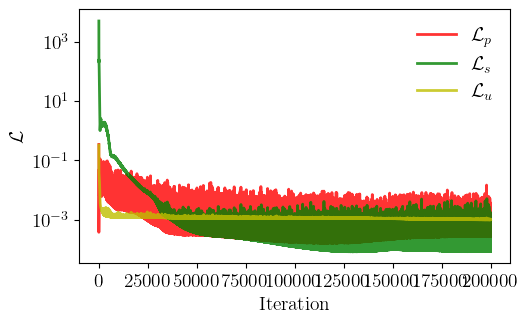

In [65]:
Nmax=len(loss)
ep = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]

loss_phip_list = [loss_fisp[i].numpy() for i in range(0,Nmax)]
loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]



plt.semilogy(ep, np.asarray(loss_phip_list), 'r-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_p$')    
plt.semilogy(ep, np.asarray(loss_phis_list), 'g-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_s$')   
plt.semilogy(ep, np.asarray(loss_data_list), 'y-', linewidth = 2, alpha=0.8, label = '$\mathcal{L}_u$')  


# plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(0.77, 0.4))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\mathcal{L}$', fontsize=14)    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/511_2/Loss_split.png')
plt.savefig('../Img/511_2/Loss_split.pdf')
plt.savefig('../Img/511_2/Loss_split.svg')
plt.show()

In [66]:
# lnv[0], tf.exp(lnv[0]), #lnv[1], tf.exp(lnv[1])

In [67]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)  
# A_star_tf = tf.convert_to_tensor(A, dtype=tf.float32)    

u_pred = predict(X_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp=u_pred[:,0:1]
lns=u_pred[:,1:2]

p=tf.exp(lnp)
s=tf.exp(lns)
a=X_star_tf[...,2:3]
# phi_s=tf.exp(net(a, W_a, b_a))
phi=net(tf.concat([p, s, a],1), W_phi, b_phi)
# phi = tf.exp(predict(s, W_phi, b_phi))


# m=tf.exp(lnv[0:1])
# l=tf.exp(lnv[1:2])


# phi_s=-np.array(p*s*m)


In [68]:
X_star_tf.shape, p.shape

(TensorShape([6498, 3]), TensorShape([6498, 1]))

In [69]:
X_star_tf[...,2:3]

<tf.Tensor: shape=(6498, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)>

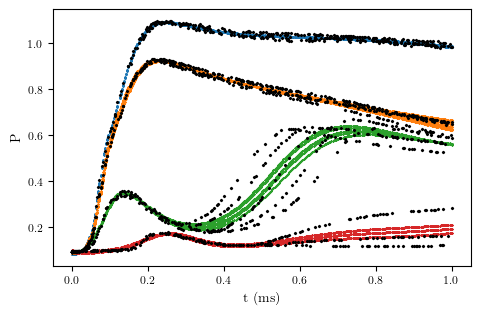

In [70]:


L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],p[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=1,  color=color, label='Prediction P')
plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')



plt.xlabel('t (ms)')
plt.ylabel('P')


# plt.legend()

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

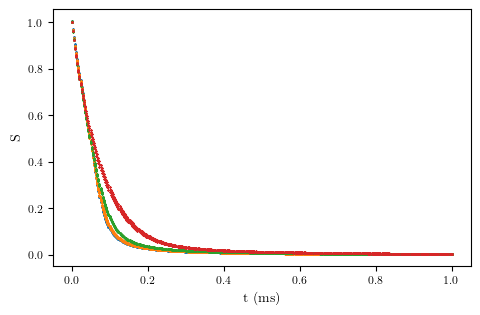

In [71]:


L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],s[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=1,  color=color, label='Prediction P')



plt.xlabel('t (ms)')
plt.ylabel('S')
# plt.yscale('log')

# plt.legend()

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [72]:


# L_exp=len(P_exp[:,1])
# colors = plt.cm.tab10.colors

# for k, j in enumerate(n):
#     # Seleccionar el color correspondiente de la paleta
#     color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
#     for i in range(j):
#         # Aquí puedes pasar el color seleccionado en cada iteración
#         # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
#         plt.scatter(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,2],l[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', color=color, label='Prediction P')



# plt.xlabel('A')
# plt.ylabel('death rate')
# # plt.yscale('log')

# # plt.legend()

# # plt.ylabel('P')
# # plt.savefig('figures/P_phi.pdf')
# plt.show()

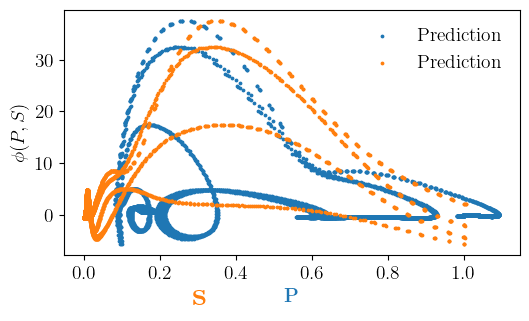

In [73]:
plt.scatter(p, phi, s=3, label='Prediction')
plt.scatter(s, phi, s=3, label='Prediction')

# plt.plot(u_pred[:,1:2], phi_pred, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel(r'$\mathbf{P}$', fontsize=14, color=colors[0])
plt.text(0.3, -0.2, r'$\mathbf{s}$', fontsize=24, color=colors[1], ha='center', transform=plt.gca().transAxes)

plt.ylabel('$\phi(P, S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/511_2/Result_phi.png')
plt.savefig('../Img/511_2/Result_phi.pdf')
plt.savefig('../Img/511_2/Result_phi.svg')
plt.show()

In [74]:
# # plt.scatter(p, phi_s, s=3, label='Prediction')

# # plt.scatter(s, phi_s, s=3, label='Prediction')
# plt.scatter(a, phi_s, s=3, label='Prediction')


# # plt.scatter(a, phi_s, s=3, label='Prediction')


# # plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# # plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
# plt.legend()
# plt.xlabel('S')
# plt.ylabel('$\phi_p(P,S)$')
# # plt.savefig('figures/phi.pdf')
# plt.show()

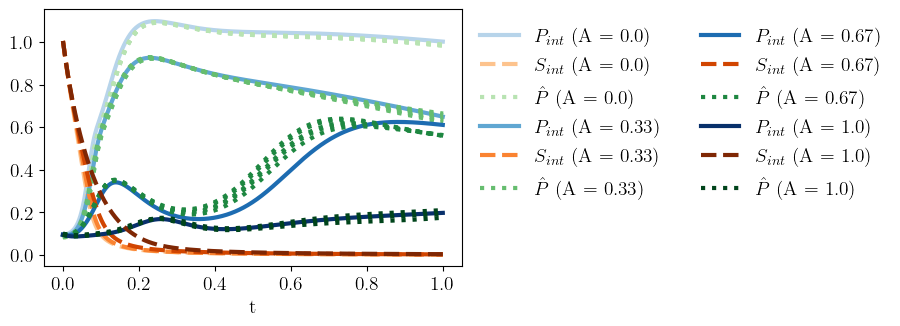

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Nt = 1000
# A_int = np.linspace(0,1,10)
colors_p = plt.cm.Blues(np.linspace(0.3, 1, len(A)))
colors_s = plt.cm.Oranges(np.linspace(0.3, 1, len(A)))
colors_t = plt.cm.Greens(np.linspace(0.3, 1, len(A)))


for idx, a_ in enumerate(A):
    T_int = np.zeros(Nt)
    P_int = np.zeros(Nt)
    S_int = np.zeros(Nt)

    dt = 0.001

    T_int[0] = 0
    P_int[0] = np.mean(P0)  # Initial conditions
    S_int[0] = np.array(s[0])  # Initial conditions

    for i in range(1, Nt):
        PSA = tf.concat(
            [
                tf.convert_to_tensor(P_int[i - 1].reshape([-1, 1]), dtype=tf.float32),
                tf.convert_to_tensor(S_int[i - 1].reshape([-1, 1]), dtype=tf.float32),
                tf.convert_to_tensor(np.array([a_]).reshape([-1, 1]), dtype=tf.float32),
            ],
            axis=1,
        )
        # PHI_S = tf.exp(net(PSA[:, 1:], W_a, b_a))

        PHI = net(PSA, W_phi, b_phi)
        P_int[i] = P_int[i - 1] + P_int[i - 1] * PHI * dt
        # S_int[i] = S_int[i - 1] - (149.725112660711*(0.00300931597230688*P_int[i - 1]+S_int[i - 1])/(0.49377868*P_int[i - 1]+S_int[i - 1])*P_int[i - 1]*S_int[i - 1])* dt
        S_int[i] = S_int[i - 1] - (149.725112660711*(0.00300931597230688*P_int[i - 1]+S_int[i - 1])/(0.49377868*P_int[i - 1]+S_int[i - 1])*P_int[i - 1]*S_int[i - 1])* dt
        T_int[i] = T_int[i - 1] + dt

    plt.plot(T_int, P_int, linewidth=3,linestyle='-', label='$P_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_p[idx])
    plt.plot(T_int, S_int,linewidth=3, linestyle='--', label='$S_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_s[idx])

    i=0
    plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx], label='$\hat{P}$'+f' (A = {np.round(A[idx], 2)})')

    for i in range(1,n[idx]):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx])




plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('t', fontsize=14)
# plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
# plt.tight_layout()
plt.savefig('../Img/511_2/Result_int.png')
plt.savefig('../Img/511_2/Result_int.pdf')
plt.savefig('../Img/511_2/Result_int.svg')
plt.show()


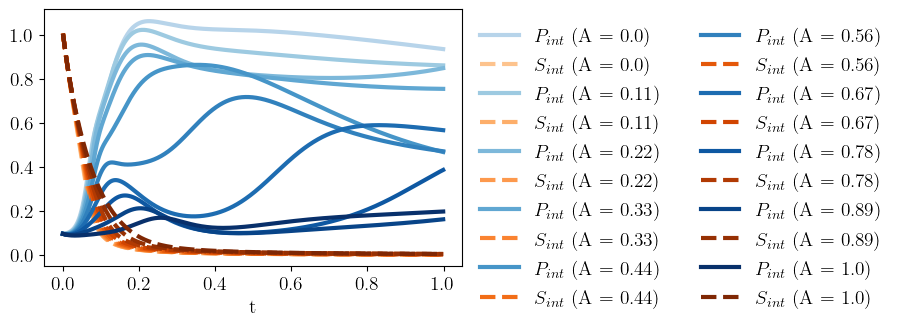

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Nt = 1000
A_int = np.linspace(0,1,10)
colors_p = plt.cm.Blues(np.linspace(0.3, 1, len(A_int)))
colors_s = plt.cm.Oranges(np.linspace(0.3, 1, len(A_int)))

for idx, a_ in enumerate(A_int):
    T_int = np.zeros(Nt)
    P_int = np.zeros(Nt)
    S_int = np.zeros(Nt)

    dt = 0.001

    T_int[0] = 0
    P_int[0] = np.mean(P0)  # Initial conditions
    S_int[0] = np.array(s[0])  # Initial conditions

    for i in range(1, Nt):
        PSA = tf.concat(
            [
                tf.convert_to_tensor(P_int[i - 1].reshape([-1, 1]), dtype=tf.float32),
                tf.convert_to_tensor(S_int[i - 1].reshape([-1, 1]), dtype=tf.float32),
                tf.convert_to_tensor(np.array([a_]).reshape([-1, 1]), dtype=tf.float32),
            ],
            axis=1,
        )
        
        PHI = net(PSA, W_phi, b_phi)
        P_int[i] = P_int[i - 1] + P_int[i - 1] * PHI * dt
        S_int[i] = S_int[i - 1] - (149.725112660711*(0.00800931597230688*P_int[i - 1]+S_int[i - 1])/(0.49377868*P_int[i - 1]+S_int[i - 1])*P_int[i - 1]*S_int[i - 1])* dt
        # S_int[i] = S_int[i - 1] - (149.725112660711*(0.00300931597230688*P_int[i - 1]+S_int[i - 1])/(0.49377868*P_int[i - 1]+S_int[i - 1])*P_int[i - 1]*S_int[i - 1])* dt
        # S_int[i] = S_int[i - 1] - ((41.966609954834*S_int[i - 1]/(0.5247405*P_int[i] + 0.5247405*S_int[i - 1]*np.array([a_]).reshape([-1, 1]) + S_int[i - 1]) - 4.95050525665283))*P_int[i - 1]*S_int[i - 1]* dt
        T_int[i] = T_int[i - 1] + dt

    plt.plot(T_int, P_int, linewidth=3,linestyle='-', label='$P_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_p[idx])
    plt.plot(T_int, S_int,linewidth=3, linestyle='--', label='$S_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_s[idx])
    # plt.scatter(X_u_train[:,0], P_train, marker='x',  color='black')


plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('t', fontsize=14)
# plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
# plt.ylim(0,1.5)
# plt.tight_layout()
plt.savefig('../Img/511_2/Result_int_2.png')
plt.savefig('../Img/511_2/Result_int_2.pdf')
plt.savefig('../Img/511_2/Result_int_2.svg')
plt.show()


In [77]:
fghj

NameError: name 'fghj' is not defined

# Symbolic Regresion

# Symbolic Regresion

In [265]:
A_symb=np.linspace(0,1,20)
T_symb=np.concatenate((np.linspace(0,0.5,60), np.linspace(0.5,1,40)))
P0=np.mean(P_exp[::L_exp])

In [200]:
X_star_symb = np.empty((0, 3))
for i in range(len(A_symb)):
    # T_meshgrid, P0_meshgrid, A_meshgrid = np.meshgrid(T_symb, P0, A_symb[i])
    x=np.hstack((T_symb.reshape([-1,1]), np.repeat(P0, len(T_symb)).reshape([-1,1]), np.repeat(A_symb[i], len(T_symb)).reshape([-1,1])))
    # x=np.hstack((T_meshgrid.flatten()[:,None], P0_meshgrid.flatten()[:,None], A_meshgrid.flatten()[:,None]))
    X_star_symb=np.vstack((X_star_symb,x))

In [201]:
A_meshgrid.shape


(3, 342, 1)

In [202]:
X_star_symb_tf=tf.convert_to_tensor(X_star_symb, dtype=tf.float32)  
u_pred = predict(X_star_symb_tf, W_p, b_p)

# ## Evaluating unknown function
lnp=u_pred[:,0:1]
lns=u_pred[:,1:2]

p_symb=tf.exp(lnp)
s_symb=tf.exp(lns)
a_symb=X_star_symb_tf[...,2:3]
# phi_s=tf.exp(net(tf.concat([p_symb, s_symb, a_symb],1), W_a, b_a))
phi=net(tf.concat([p_symb, s_symb, a_symb],1), W_phi, b_phi)

In [203]:
L_symb=len(T_symb)


In [204]:
L_symb

100

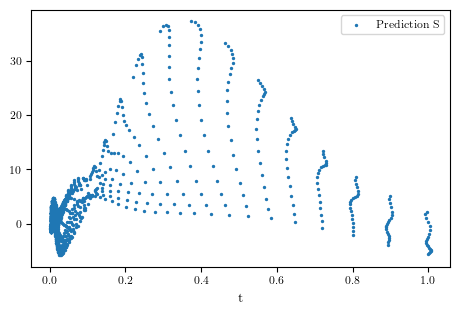

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.    , 0.0921, 0.    ], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.9970674, 0.0975   , 1.       ], dtype=float32)>)

In [205]:
c=0
d=-1
# plt.scatter( p_symb[c:d], phi[c:d], s=2, label='Prediction P')
plt.scatter( s_symb[c:d], phi[c:d], s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()
X_star_tf[c:d][0], X_star_tf[c:d][-1]

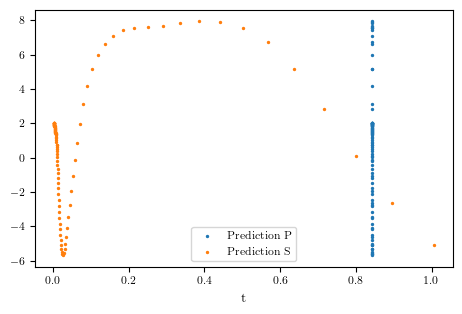

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.6803515, 0.093    , 0.       ], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.9706745, 0.093    , 0.       ], dtype=float32)>)

In [206]:
i=16
c=L_symb*i
d=L_symb*(i+1)
plt.scatter( a_symb[c:d], phi[c:d], s=2, label='Prediction P')
plt.scatter( s_symb[c:d], phi[c:d], s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()
X_star_tf[c:d][0], X_star_tf[c:d][-1]

In [207]:
# c=0
# d=-1
# plt.scatter( p_symb[c:d], phi_s[c:d], s=2, label='Prediction P')
# plt.scatter( s_symb[c:d], phi_s[c:d], s=2, label='Prediction S')
# # plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


# plt.legend()
# plt.xlabel('t')
# # plt.ylabel('P')
# # plt.savefig('figures/P_phi.pdf')
# plt.show()
# X_star_tf[c:d][0], X_star_tf[c:d][-1]

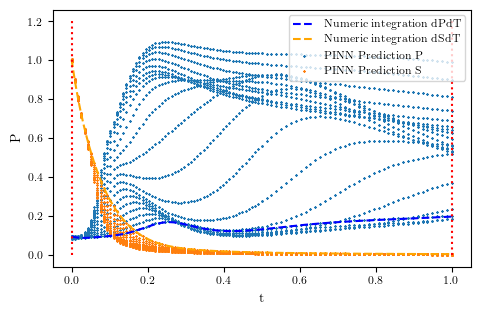

In [208]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')




plt.scatter(X_star_symb_tf[:,0], p_symb, marker='x', s=1,  label='PINN Prediction P')
plt.scatter(X_star_symb_tf[:,0], s_symb, marker='x', s=1,  label='PINN Prediction S')


plt.vlines(X_star_symb_tf[c:d][:,0][0],0,1.2, color='red', linestyle=':')
plt.vlines(X_star_symb_tf[c:d][:,0][-1],0,1.2, color='red', linestyle=':')


plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

In [239]:
# Create and train the PySR model
model_phi= PySRRegressor(
    niterations=300,
    # binary_operators=["+", "*", "/"],
    binary_operators=["+", "*", "inv(x, y) = x/(x + y)"],
    # unary_operators=["inv(x) = 1/x"],
    # unary_operators=["exp","inv(x) = 1/x"],
    # unary_operators=["exp", "cos"],
    # elementwise_loss="myloss(x, y, w) = w*(x - y)^2",

    extra_sympy_mappings={"inv": lambda x, y: x/(x+y),},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    complexity_of_variables=1,
    complexity_of_constants=1,
    complexity_of_operators={"inv":3},
    parsimony=0.000000000001,
    # select_k_features=1,
    # constraints={"cos": 5, "exp":5, "inv":(1, -1)},
    # constraints={"^": (-1,1)},
    maxsize=40,
    # denoise=True,
    progress=True  # Show progress during training
)

In [240]:
# # Create and train the PySR model
# model_phi= PySRRegressor(
#     niterations=100,
#     binary_operators=["+", "*", "inv(x, y) = x/(x + y)"],
#     # binary_operators=["+", "*", "inv(x, y) = x/(x + y)"],
#     # unary_operators=["inv(x) = 1/x"],
#     # unary_operators=["exp","inv(x) = 1/x"],
#     unary_operators=["exp", "cos"],
#     elementwise_loss="myloss(x, y, w) = w*(x - y)^2",

#     extra_sympy_mappings={"inv": lambda x, y: x/(x+y),},
#     # elementwise_loss="loss(prediction, target) = (prediction - target)^2",
#     complexity_of_variables=1,
#     complexity_of_constants=1,
#     complexity_of_operators={"inv": 3, "cos":2, "exp":2},
#     # parsimony=0.0000001,
#     # select_k_features=1,
#     constraints={"cos": 5, "exp":5},
#     maxsize=30,
#     # denoise=True,
#     # progress=True  # Show progress during training
# )

In [241]:
# p1s=tf.concat([p1[c:d], s[c:d]], axis=1)

min_cols_phi_p= tf.math.reduce_min(phi, axis=0)
max_cols_phi_p= tf.math.reduce_max(phi, axis=0)

phi_p_scaled = (phi-min_cols_phi_p)/(max_cols_phi_p-min_cols_phi_p)

# min_cols_phi_s= tf.math.reduce_min(phi_s, axis=0)
# max_cols_phi_s= tf.math.reduce_max(phi_s, axis=0)

# phi_s_scaled = (phi_s-min_cols_phi_s)/(max_cols_phi_s-min_cols_phi_s)

PSA_tf=tf.concat([p_symb, s_symb, a_symb],1)
# PHI_SCALED_tf=tf.concat([phi_p_scaled, phi_s_scaled],1)

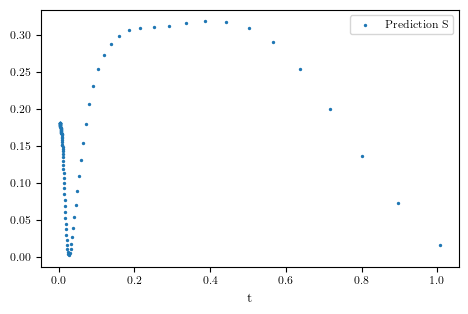

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.6803515, 0.093    , 0.       ], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.9706745, 0.093    , 0.       ], dtype=float32)>)

In [242]:
i=16
c=L_symb*i
d=L_symb*(i+1)
# plt.scatter( p_symb[c:d], phi[c:d], s=2, label='Prediction P')
plt.scatter( s_symb[c:d], phi_p_scaled[c:d], s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()
X_star_tf[c:d][0], X_star_tf[c:d][-1]

C:\Users\julia\AppData\Local\Temp\ipykernel_16960\3231873631.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición


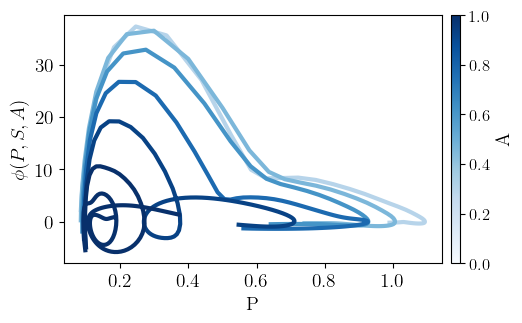

In [266]:
import matplotlib.cm as cm

# Configuración de la colormap
norm = plt.Normalize(vmin=min(A_symb), vmax=max(A_symb))  # Normaliza los valores de A_symb
cmap = cm.Blues  # Puedes cambiar "viridis" por otro mapa de colores
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para asociar el colorbar

# Plot con color asociado a A_symb
for idx, a_ in enumerate(A_symb[::3]):
    idx*=3
    c = len(T_symb) * idx
    d = len(T_symb) * (idx + 1)
    plt.plot(
        p_symb[c:d],
        phi[c:d],
        linewidth=3,
        linestyle='-',
        color=cmap(norm(a_+0.3))  # Asocia el color correspondiente a a_
    )

# Añade la colorbar
cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición
cbar.set_label('A', fontsize=14)  # Etiqueta de la colorbar
cbar.ax.tick_params(labelsize=12)

# Ejes y configuración
plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P,S,A)$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig('../Img/511_2/Phi_p.png')
plt.savefig('../Img/511_2/Phi_p.pdf')
plt.savefig('../Img/511_2/Phi_p.svg')
plt.show()


C:\Users\julia\AppData\Local\Temp\ipykernel_16960\2934127624.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición


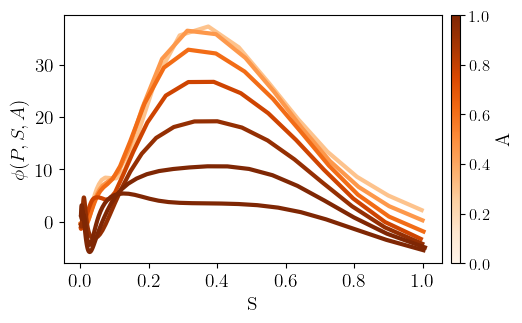

In [267]:
import matplotlib.cm as cm

# Configuración de la colormap
norm = plt.Normalize(vmin=min(A_symb), vmax=max(A_symb))  # Normaliza los valores de A_symb
cmap = cm.Oranges  # Puedes cambiar "viridis" por otro mapa de colores
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para asociar el colorbar

# Plot con color asociado a A_symb
for idx, a_ in enumerate(A_symb[::3]):
    idx*=3
    c = len(T_symb) * idx
    d = len(T_symb) * (idx + 1)
    plt.plot(
        s_symb[c:d],
        phi[c:d],
        linewidth=3,
        linestyle='-',
        color=cmap(norm(a_+0.3))  # Asocia el color correspondiente a a_
    )

# Añade la colorbar
cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición
cbar.set_label('A', fontsize=14)  # Etiqueta de la colorbar
cbar.ax.tick_params(labelsize=12)

# Ejes y configuración
plt.xlabel('S', fontsize=14)
plt.ylabel('$\phi(P,S,A)$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig('../Img/511_2/Phi_s.png')
plt.savefig('../Img/511_2/Phi_s.pdf')
plt.savefig('../Img/511_2/Phi_s.svg')
plt.show()


C:\Users\julia\AppData\Local\Temp\ipykernel_16960\2375301123.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición


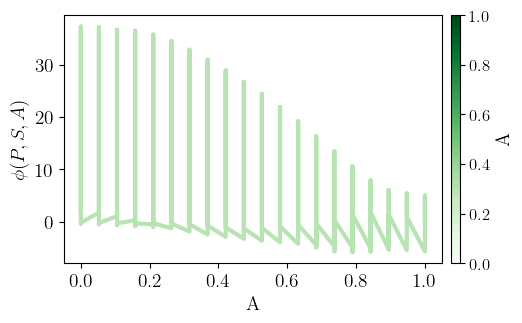

In [245]:
import matplotlib.cm as cm

# Configuración de la colormap
norm = plt.Normalize(vmin=min(A_symb), vmax=max(A_symb))  # Normaliza los valores de A_symb
cmap = cm.Greens  # Puedes cambiar "viridis" por otro mapa de colores
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para asociar el colorbar

# Plot con color asociado a A_symb
for idx, a_ in enumerate(A_symb[::3]):
    idx*=3
    c = len(T_symb) * idx
    d = len(T_symb) * (idx + 1)
    plt.plot(
        a_symb[c:d],
        phi[c:d],
        linewidth=3,
        linestyle='-',
        color=cmap(norm(a_+0.3))  # Asocia el color correspondiente a a_
    )

# Añade la colorbar
cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición
cbar.set_label('A', fontsize=14)  # Etiqueta de la colorbar
cbar.ax.tick_params(labelsize=12)

# Ejes y configuración
plt.xlabel('A', fontsize=14)
plt.ylabel('$\phi(P,S,A)$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig('../Img/511_2/Phi_a.png')
plt.savefig('../Img/511_2/Phi_a.pdf')
plt.savefig('../Img/511_2/Phi_a.svg')
plt.show()


In [246]:
# np.save('SA_symb',tf.concat([s_symb, a_symb],1) )
# np.save('PHI_symb',phi_p_scaled )



In [247]:
# model_phi.fit(tf.concat([s_symb, a_symb],1), phi_p_scaled,  weights=(-2*(0.8-s_symb)**2+4)[:,0])
model_phi.fit(tf.concat([p_symb, s_symb, a_symb],1), phi_p_scaled)
print(model_phi)


c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.630e+04
Head worker occupation: 20.9%
Progress: 123 / 4500 total iterations (2.733%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
3           1.972e-02  5.314e+00  y = 0.0897 + 0.0897
5           1.560e-02  1.172e-01  y = 0.16275 + (x₁ * x₀)
7           9.978e-03  2.235e-01  y = 0.11013 + (4.1609 * (x₀ * x₁))
11          7.894e-03  5.858e-02  y = 0.09536 + (3.1704 * (inv(x₀, x₁) * x₁))
13          6.712e-03  8.106e-02  y = (5.53 * (inv(x₀, x₁ + x₂) * x₁)) + 0.10219
15          5.297e-03  1.184e-01  y = (x₁ * (2.9222 * inv(x₀, x₁ * (x₂ + x₁)))) + 0.096347
17          4.327e-03  1.011e-01  y = ((2.9222 * inv(x₀, x₁ * (x₂ + (x₁ * x₁)))) * x₁) + 0.09634...
                                  7
19          4.077e-03  2.983e-02  y = (x₁ * (2.9222 * inv(x₀, (x₂ * x₂) + ((x₁ * x₁) * x₁)))) + ...
                                  0.096347
21          

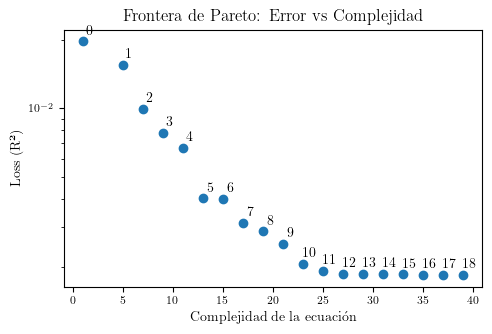

In [248]:
# Extraer las métricas de las ecuaciones
equations_df = model_phi.equations_
# equations_df_p = pd.DataFrame(equations_df[0])
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')

plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.yscale('log')
plt.show()

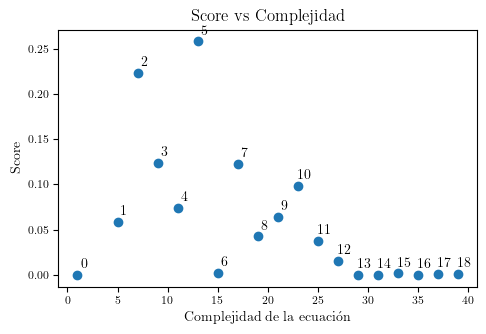

In [249]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [250]:
equations_df


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.019723,0.000000,0.17939584,0.179395840000000,PySRFunction(X=>0.179395840000000)
1,5,0.015602,0.058601,0.1627546 + (x0 * x1),x0*x1 + 0.1627546,PySRFunction(X=>x0*x1 + 0.1627546)
2,7,0.009978,0.223506,0.11012556 + (4.1609106 * (x0 * x1)),4.1609106*x0*x1 + 0.11012556,PySRFunction(X=>4.1609106*x0*x1 + 0.11012556)
3,9,0.007784,0.124169,0.11566962 + ((1.8816409 + (-2.046462 * x1)) *...,x1*(1.8816409 - 2.046462*x1) + 0.11566962,PySRFunction(X=>x1*(1.8816409 - 2.046462*x1) +...
4,11,0.006713,0.074006,0.09789357 + (((x0 * 6.879037) + (-0.5569187 *...,x1*(x0*6.879037 - 0.5569187*x1) + 0.09789357,PySRFunction(X=>x1*(x0*6.879037 - 0.5569187*x1...
5,13,0.004005,0.258225,"0.10631441 + (x1 * (inv(x0 + -0.08783886, 0.14...",x1*((x0 - 0.08783886)/(x0 + 0.05591543))*3.615...,PySRFunction(X=>x1*((x0 - 0.08783886)/(x0 + 0....
6,15,0.003986,0.002425,"(x1 * (inv(-0.08678921 + x0, 0.16778432) * (3....",x1*((x0 - 0.08678921)/(x0 + 0.08099511))*(x1 +...,PySRFunction(X=>x1*((x0 - 0.08678921)/(x0 + 0....
7,17,0.003116,0.123048,0.10513971 + (x1 * (2.8477561 * inv(x0 + -0.08...,x1*2.8477561*((x0 - 0.08484307)/(x0 + (x1 + x2...,PySRFunction(X=>x1*2.8477561*((x0 - 0.08484307...
8,19,0.002862,0.042488,"((inv(-0.44570526 + (x0 * 5.375047), (x1 * x1)...",((x0*5.375047 - 0.44570526)/(x0*5.375047 + x1*...,PySRFunction(X=>((x0*5.375047 - 0.44570526)/(x...
9,21,0.002517,0.064274,"(x1 * (-0.30017757 + (3.700371 * inv(x0, ((x1 ...",x1*(3.700371*(x0/(x0 + x1*x1*x1 + 0.3515227*x2...,PySRFunction(X=>x1*(3.700371*(x0/(x0 + x1*x1*x...


In [251]:
for i in range(len(equations_df)):

    print(i, sympy.simplify(model_phi.sympy(i))*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)

0 1.96083365580200
1 43.0774078369141*x0*x1 + 1.24397217341003
2 179.241242889139*x0*x1 - 1.02315044673523
3 -43.0774078369141*x1*(2.046462*x1 - 1.8816409) - 0.784326713042907
4 43.0774078369141*x1*(6.879037*x0 - 0.5569187*x1) - 1.55007286862228
5 -5.76707410812378 + 43.0774078369141*(0.10631441*x0 + 3.6157825*x1*(x0 - 0.08783886) + 0.0059446159503463)/(x0 + 0.05591543)
6 -5.76707410812378 + 43.0774078369141*(0.10817755*x0 + x1*(x0 - 0.08678921)*(x1 + 3.6015217) + 0.0087618525617805)/(x0 + 0.08099511)
7 122.67395093976*x1*(x0 - 0.08484307)/(x0 + 0.11016194*x1 + 0.11016194*x2 - 0.08484307) - 1.23792794059891
8 -5.76707410812378 + 43.0774078369141*(0.58526451886709*x0 + 0.10888547*x1**2 + 3.0301814*x1*(5.375047*x0 - 0.44570526) + 0.10888547*x2 - 0.0485308267165722)/(5.375047*x0 + x1**2 + x2 - 0.44570526)
9 43.0774078369141*x1*(3.700371*x0/(x0 + x1**3 + 0.3515227*x2) - 0.30017757) - 1.13493761239426
10 43.0774078369141*x1*(2.7982707*x0/(x0 + x1*(x1 - 0.35340425) + 0.36792594*x2**2) - 0.31

In [252]:

for i in range(len(equations_df)):
    print(i, sympy.expand(model_phi.sympy(i))*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)

0 1.96083365580200
1 43.0774078369141*x0*x1 + 1.24397217341003
2 179.241242889139*x0*x1 - 1.02315044673523
3 -88.1562781967468*x1**2 + 81.056212451918*x1 - 0.784326713042907
4 296.331082374222*x0*x1 - 23.990613971904*x1**2 - 1.55007286862228
5 155.758537402077*x0*x1/(x0 + 0.05591543) - 13.6816523606658*x1/(x0 + 0.05591543) - 1.18732490961288
6 43.0774078369141*x0*x1**2/(x0 + 0.08099511) + 155.144219104396*x0*x1/(x0 + 0.08099511) - 3.73865419501358*x1**2/(x0 + 0.08099511) - 13.4648442121374*x1/(x0 + 0.08099511) - 1.10706566797562
7 122.67395093976*x0*x1/(x0 + 0.11016194*x1 + 0.11016194*x2 - 0.08484307) - 10.4080346067586*x1/(x0 + 0.11016194*x1 + 0.11016194*x2 - 0.08484307) - 1.23792794059891
8 701.617569954437*x0*x1/(5.375047*x0 + x1**2 + x2 - 0.44570526) - 58.1789594467008*x1/(5.375047*x0 + x1**2 + x2 - 0.44570526) - 1.07657030941971
9 159.40239071489*x0*x1/(x0 + x1**3 + 0.3515227*x2) - 12.9308716063838*x1 - 1.13493761239426
10 120.542248181987*x0*x1/(x0 + x1**2 - 0.35340425*x1 + 0.367

In [253]:
for i in range(len(equations_df)):
    print(i, sympy.factor(model_phi.sympy(i))*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)

0 1.96083365580200
1 43.0774078369141*x0*x1 + 1.24397217341003
2 179.241242889139*x0*x1 - 1.02315044673523
3 -88.1562781967468*x1**2 + 81.056212451918*x1 - 0.784326713042907
4 296.331082374222*x0*x1 - 23.990613971904*x1**2 - 1.55007286862228
5 -5.76707410812378 + 155.758537402077*(1.0*x0*x1 + 0.0294028775237449*x0 - 0.08783886*x1 + 0.00164407453997753)/(1.0*x0 + 0.05591543)
6 -5.76707410812378 + 155.144219104396*(0.277660412264072*x0*x1**2 + 1.0*x0*x1 + 0.0300366231307172*x0 - 0.0240979278286731*x1**2 - 0.08678921*x1 + 0.00243281959450099)/(1.0*x0 + 0.08099511)
7 -5.76707410812378 + 122.67395093976*(1.0*x0*x1 + 0.0369201948158411*x0 - 0.080775869713909*x1 + 0.004067200286091*x2 - 0.00313242267317405)/(1.0*x0 + 0.11016194*x1 + 0.11016194*x2 - 0.08484307)
8 -5.76707410812378 + 130.532359987631*(1.0*x0*x1 + 0.0359336474047395*x0 + 0.00668527129246303*x1**2 - 0.0829211837589513*x1 + 0.00668527129246303*x2 - 0.00297966057957777)/(1.0*x0 + 0.186044884816821*x1**2 + 0.186044884816821*x2 - 0.0

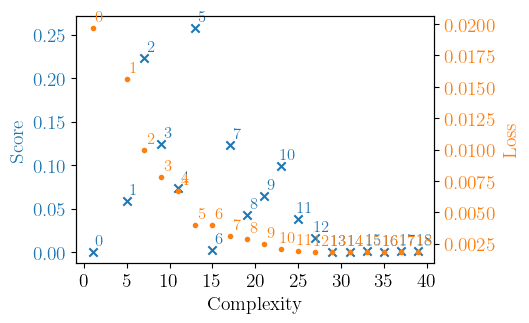

In [254]:
import matplotlib.pyplot as plt

# Obtener los colores de la paleta tab10
colors = plt.get_cmap('tab10').colors

# Crear la figura y el primer eje (izquierdo)
fig, ax1 = plt.subplots()

# Graficar score vs complejidad en el eje izquierdo usando el color tab10[0]
ax1.scatter(complejidades, scores, color=colors[0], marker='x', label='Score')
ax1.set_xlabel('Complexity', fontsize=14)
ax1.set_ylabel('Score', fontsize=14, color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

# Añadir etiquetas de índice en cada punto para score
for i, (x, y) in enumerate(zip(complejidades, scores)):
    ax1.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color=colors[0])

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# Crear un segundo eje (derecho) que comparte el eje x
ax2 = ax1.twinx()

# Graficar errores vs complejidad en el eje derecho usando el color tab10[1]
ax2.scatter(complejidades, errores, color=colors[1], s=9, marker='o', label='Loss')
ax2.set_ylabel('Loss', fontsize=14, color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

# Añadir etiquetas de índice en cada punto para errores
for i, (x, y) in enumerate(zip(complejidades, errores)):
    ax2.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color=colors[1])

# Ajustar el gráfico para que no se corten los elementos
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig('../Img/511_2/Score_Loss_Complexity.png')
plt.savefig('../Img/511_2/Score_Loss_Complexity.pdf')
plt.savefig('../Img/511_2/Score_Loss_Complexity.svg')
plt.show()


In [255]:
choose_p=4
choose_p_2=7
choose_p_3=len(equations_df)-1


exp=model_phi.sympy(choose_p)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
exp_2=model_phi.sympy(choose_p_2)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
exp_3=model_phi.sympy(choose_p_3)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p

# exp=model_phi.sympy(choose_p)
# exp_2=model_phi.sympy(choose_p_2)
# exp_3=model_phi.sympy(choose_p_3)

In [256]:
sympy.factor(exp)

296.331082374222*(1.0*x0*x1 - 0.0809588173460907*x1**2 - 0.00523088181031504)

In [257]:
sympy.factor(exp_2)



122.67395093976*(1.0*x0*x1 - 0.0100912046209941*x0 - 0.0859547366779857*x1 - 0.00111166667798567*x2 + 0.000856168780043326)/(1.0*x0 + 0.11016194*x1 + 0.11016194*x2 - 0.08484307)

In [258]:
sympy.factor(exp_3)


-19.8813049596725*(1.0*x1**4 + 0.2946244*x1**3*x2**2 + 0.0073005890465396*x1**3*x2 + 0.05747248464565*x1**3 + 0.2946244*x1**2*x2**3 - 0.117254526304339*x1**2*x2**2 - 0.00308638969081005*x1**2*x2 - 0.735956683149332*x1**2 + 0.145776383296402*x1*x2**3 + 3.91031107115508e-5*x1*x2**2 - 8.85398146751737e-5*x1*x2 - 0.250842694342279*x1 + 0.00371689584399431*x2**3 + 9.21021106391507e-5*x2**2 + 0.0017055581384851)/(1.0*x1**3 + 0.2946244*x1**2*x2**2 + 0.0073005890465396*x1**2*x2 + 0.03050548*x1**2 + 0.2946244*x1*x2**3 - 0.12519966386786*x1*x2**2 - 0.00328326470954407*x1*x2 - 0.069391459773344*x1 + 0.13783124573288*x2**3 + 0.00341536302786996*x2**2 + 0.06324610986264)

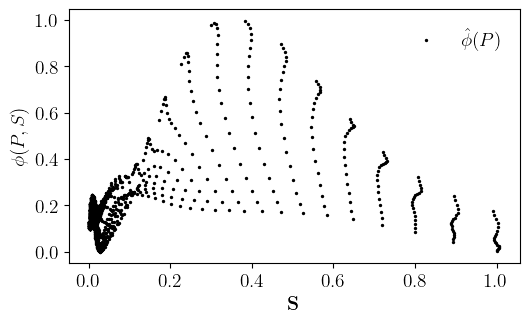

In [259]:
# i=0
# symb1=model_phi.predict(SA_tf,choose_p)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)
# symb2=model_phi.predict(SA_tf,choose_p_2)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)
# symb3=model_phi.predict(SA_tf,choose_p_3)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)

# symb1=model_phi.predict(SA_tf,choose_p)
# symb2=model_phi.predict(SA_tf,choose_p_2)
# symb3=model_phi.predict(SA_tf,choose_p_3)

# symb1=model_phi_phi.predict(s,choose,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)
# symb2=model_phi_phi.predict(s,choose_2,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)
# symb3=model_phi_phi.predict(s,choose_3,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)


plt.scatter(s_symb[L_symb:], phi_p_scaled[L_symb:],linewidth= 1,s=2, color='black', label='$\hat{\phi}(P)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], phi[L_symb*i:L_symb*(i+1)],linewidth=1, color='gray', label='$\hat{\phi}(S)$')

# plt.scatter(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
# plt.scatter(s_symb, symb1,linewidth=1, color=colors[0], s=2, linestyle=':', label='$\phi^s_5(P)$')
# plt.scatter(s_symb, symb2,linewidth=1, color=colors[1],s=2, linestyle='--', label='$\phi^s_{10}(P)$')
# plt.scatter(s_symb, symb3,linewidth=1, color=colors[2],s=2,linestyle='-.', label='$\phi^s_{14}(P)$')
# # plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_5(S)$')
# # plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_{10}(S)$')
# # plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_{14}(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


plt.xlabel(r'$\mathbf{S}$', fontsize=14, color='black')
# plt.text(0.3, -0.2, r'$\mathbf{s}$', fontsize=24, color='gray', ha='center', transform=plt.gca().transAxes)


# plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
# plt.savefig('../Img/511_2/Result_phi_s.png')
# plt.savefig('../Img/511_2/Result_phi_s.pdf')
# plt.savefig('../Img/511_2/Result_phi_s.svg')
plt.show()


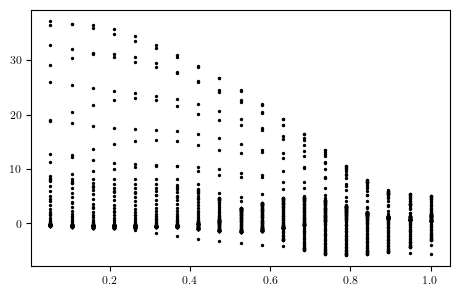

In [260]:
plt.scatter(a_symb[L_symb:], phi[L_symb:],linewidth= 1,s=2, color='black', label='$\hat{\phi}(P)$')


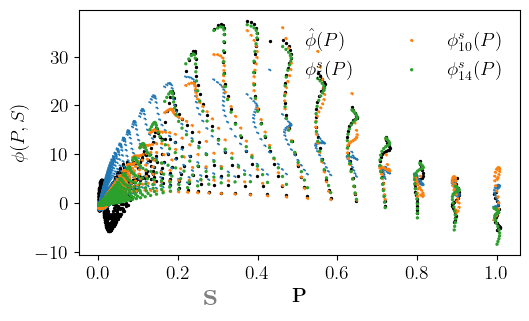

In [261]:
i=0
symb1=model_phi.predict(PSA_tf,choose_p)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
symb2=model_phi.predict(PSA_tf,choose_p_2)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
symb3=model_phi.predict(PSA_tf,choose_p_3)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p

# symb1=model_phi.predict(SA_tf,choose_p)
# symb2=model_phi.predict(SA_tf,choose_p_2)
# symb3=model_phi.predict(SA_tf,choose_p_3)

# symb1=model_phi_phi.predict(s,choose,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)
# symb2=model_phi_phi.predict(s,choose_2,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)
# symb3=model_phi_phi.predict(s,choose_3,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p)


plt.scatter(s_symb, phi,linewidth= 1,s=2, color='black', label='$\hat{\phi}(P)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], phi[L_symb*i:L_symb*(i+1)],linewidth=1, color='gray', label='$\hat{\phi}(S)$')

# plt.scatter(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.scatter(s_symb, symb1,linewidth=1, color=colors[0], s=2, linestyle=':', label='$\phi^s_5(P)$')
plt.scatter(s_symb, symb2,linewidth=1, color=colors[1],s=2, linestyle='--', label='$\phi^s_{10}(P)$')
plt.scatter(s_symb, symb3,linewidth=1, color=colors[2],s=2,linestyle='-.', label='$\phi^s_{14}(P)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_5(S)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_{10}(S)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_{14}(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


plt.xlabel(r'$\mathbf{P}$', fontsize=14, color='black')
plt.text(0.3, -0.2, r'$\mathbf{s}$', fontsize=24, color='gray', ha='center', transform=plt.gca().transAxes)


# plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
# plt.savefig('../Img/511_2/Result_phi_s.png')
# plt.savefig('../Img/511_2/Result_phi_s.pdf')
# plt.savefig('../Img/511_2/Result_phi_s.svg')
plt.show()


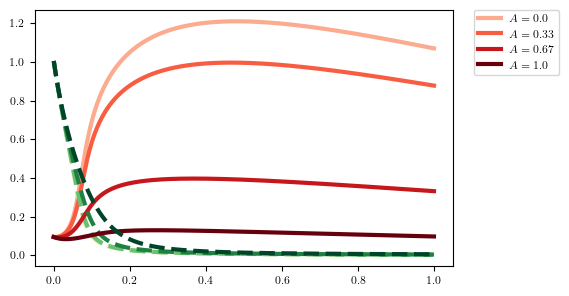

In [269]:
Nt=1000

A_int=np.array([0,0.75, 1.25,2, 2.5,3,3.75])

colors_p = plt.cm.Reds(np.linspace(0.3, 1, len(A)))
colors_s = plt.cm.YlGn(np.linspace(0.3, 1, len(A)))
for idx, a_ in enumerate(A):

    T_symb=np.zeros(Nt)
    P_symb=np.zeros(Nt)
    S_symb=np.zeros(Nt)


    dt=0.001

    T_symb[0]=0
    P_symb[0]=np.mean(P0) #Initial conditions
    # P_symb[0]=np.array(p[0]) #Initial conditions

    S_symb[0]=np.array(s[0]) #Initial conditions

    for i in range(1,Nt):

        PSA=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        
        # PHI=net(PSA, W_phi, b_phi)
        PHI=model_phi.predict(PSA,choose_p_3)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
        # REVISAAAAAR
        # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        P_symb[i] = P_symb[i - 1] + P_symb[i - 1] * PHI * dt
        S_symb[i] = S_symb[i - 1] - (149.725112660711*(0.00300931597230688*P_symb[i - 1]+S_symb[i - 1])/(0.49377868*P_symb[i - 1]+S_symb[i - 1])*P_symb[i - 1]*S_symb[i - 1])* dt
        T_symb[i] = T_symb[i - 1] + dt

    plt.plot(T_symb, P_symb, linewidth=3, linestyle='-', label=f'$A = {np.round(a_, 2)}$', color=colors_p[idx])
    plt.plot(T_symb, S_symb, linewidth=3, linestyle='--', color=colors_s[idx])

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.savefig('../Img/511_2/Result_symb_2.png')
plt.savefig('../Img/511_2/Result_symb_2.pdf')
plt.savefig('../Img/511_2/Result_symb_2.svg')
plt.show()

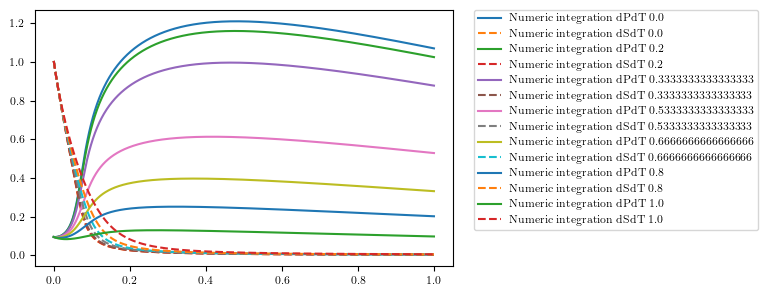

In [263]:
Nt=1000

A_int=np.array([0,0.75, 1.25,2, 2.5,3,3.75])


for a_ in A_int/np.max(A_int):

    T_symb=np.zeros(Nt)
    P_symb=np.zeros(Nt)
    S_symb=np.zeros(Nt)


    dt=0.001

    T_symb[0]=0
    P_symb[0]=np.mean(P0) #Initial conditions
    # P_symb[0]=np.array(p[0]) #Initial conditions

    S_symb[0]=np.array(s[0]) #Initial conditions

    for i in range(1,Nt):

        PSA=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        
        # PHI=net(PSA, W_phi, b_phi)
        PHI=model_phi.predict(PSA,choose_p_3)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
        # REVISAAAAAR
        # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        P_symb[i] = P_symb[i - 1] + P_symb[i - 1] * PHI * dt
        S_symb[i] = S_symb[i - 1] - (149.725112660711*(0.00300931597230688*P_symb[i - 1]+S_symb[i - 1])/(0.49377868*P_symb[i - 1]+S_symb[i - 1])*P_symb[i - 1]*S_symb[i - 1])* dt
        T_symb[i] = T_symb[i - 1] + dt

    plt.plot(T_symb, P_symb,  linestyle='-', label=f'Numeric integration dPdT {a_}')
    plt.plot(T_symb, S_symb,  linestyle='--', label=f'Numeric integration dSdT {a_}')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

In [264]:
sgfdhgjhj

NameError: name 'sgfdhgjhj' is not defined

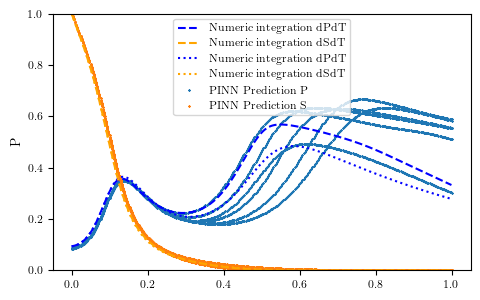

In [ ]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')

plt.plot(T_symb, P_symb, color='blue', linestyle=':', label='Numeric integration dPdT')
plt.plot(T_symb, S_symb, color='orange', linestyle=':', label='Numeric integration dSdT')

plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
plt.scatter(X_star_tf[:,0], s, marker='x', s=1,  label='PINN Prediction S')
# plt.xlabel('t')
plt.ylabel('P')
plt.ylim(0,1)
plt.legend()
plt.show()

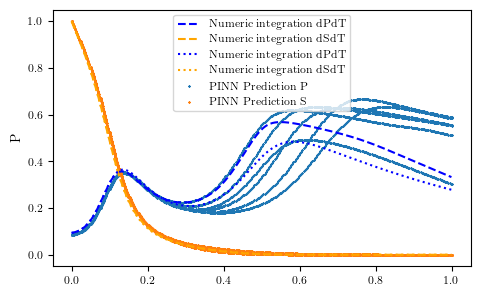

In [ ]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')

plt.plot(T_symb, P_symb, color='blue', linestyle=':', label='Numeric integration dPdT')
plt.plot(T_symb, S_symb, color='orange', linestyle=':', label='Numeric integration dSdT')

plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
plt.scatter(X_star_tf[:,0], s, marker='x', s=1,  label='PINN Prediction S')
# plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

In [ ]:
m, l

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[42.86948]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[6.1390066]], dtype=float32)>)

Soluciones de f(S) = 0: [7.00220078e-04 3.67713783e-02 2.89489556e-01 2.89489556e-01
 2.89489556e-01 2.89489556e-01 2.89489556e-01 2.89489556e-01
 2.89489556e-01 1.02094028e+00 1.02094028e+00 1.02094028e+00
 1.31517768e+00]


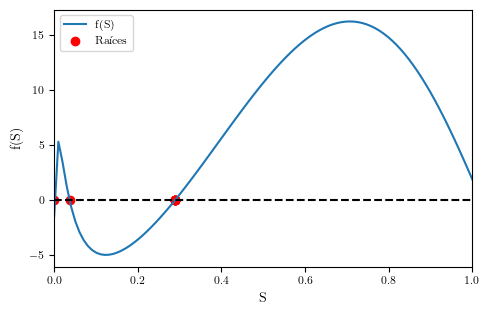

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import sympy as sp

P, S = sp.symbols('P S')

# Definir la función que representa el sistema de ecuaciones
def system(vars):
    P, S = vars
    f_S = expr.subs({'x1': S})-6.1390066  # Cambia esta expresión por la de tu función f(S)
    dP = f_S * P 
    dS = -42.86948 * S * P
    return [dP, dS]


# Definir variables simbólicas
# P, S = sp.symbols('P S')
# Define tu función f(S) y asegúrate de que solo depende de S
f_S = expr.subs({'x1': S})-6.1390066   # Define aquí la función f(S) correctamente

# Convertir f(S) en una función numérica
f_S_func = sp.lambdify(S, f_S, 'numpy')

# Rango para el diagrama de fases
S_values = np.linspace(0, 1, 50)
P_values = np.linspace(0, 1, 50)

# Crear la cuadrícula
P_grid, S_grid = np.meshgrid(P_values, S_values)
dP_vals = f_S_func(S_grid) * P_grid
dS_vals = -42.86948 * S_grid * P_grid

# Encontrar los puntos fijos usando fsolve
fixed_points = []
for P_init in np.linspace(0, 1, 50):  # Asegúrate de elegir un buen rango de inicialización
    for S_init in np.linspace(0, 1, 50):
        point = fsolve(system, [P_init, S_init])
        # Evitar duplicados al agregar puntos
        if not any(np.allclose(point, fp) for fp in fixed_points):
            fixed_points.append(point)



import scipy.optimize as opt


# Usar fsolve para encontrar las raíces de f(S) en un rango inicial
S_initial_guesses = np.linspace(0, 1, 20)  # Puedes ajustar el rango de las conjeturas iniciales
S_roots = [opt.fsolve(f_S_func, S0) for S0 in S_initial_guesses]

# Imprimir las soluciones
S_roots = np.unique(np.array(S_roots).flatten())  # Aplanar el resultado para eliminar listas anidadas
print("Soluciones de f(S) = 0:", S_roots)

# Graficar las soluciones
S_values = np.linspace(0, 1, 100)
f_values = f_S_func(S_values)

plt.plot(S_values, f_values, label="f(S)")
plt.axhline(0, color='black', linestyle='--')
plt.scatter(S_roots, f_S_func(S_roots), color='red', label='Raíces')
plt.xlabel('S')
plt.ylabel('f(S)')
plt.legend()
plt.xlim(0,1)
plt.show()



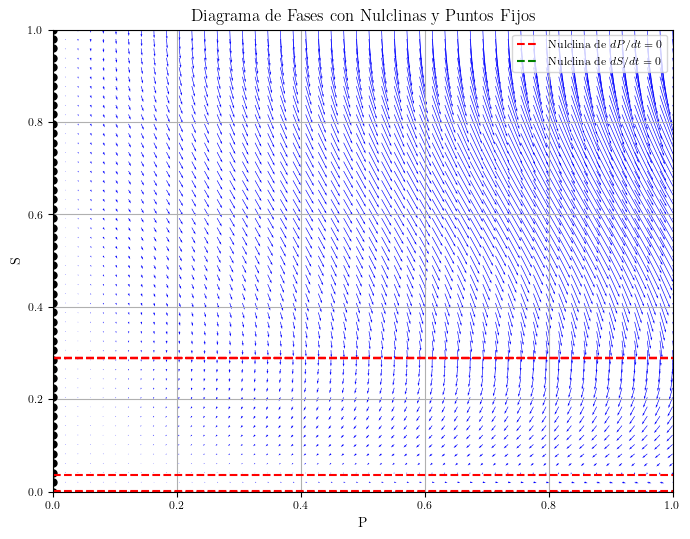

In [ ]:
# Graficar el diagrama de fases con nulclinas y puntos fijos
plt.figure(figsize=(8, 6))
# plt.quiver(P_grid, S_grid, dP_vals, dS_vals, color='blue', alpha=0.5,scale=1, width=0.005)
plt.quiver(P_grid, S_grid, dP_vals, dS_vals, color='blue',scale=500, width=0.001)


# Graficar las nulclinas (solo como ejemplo)
plt.axhline(0, color='r', linestyle='--', label='Nulclina de $dP/dt = 0$')
plt.axvline(0, color='g', linestyle='--', label='Nulclina de $dS/dt = 0$')

# Graficar los puntos fijos
for point in fixed_points:
    P_val, S_val = point
    plt.plot(P_val, S_val, 'ko', markersize=5)

for nulclina_P in S_roots:
    plt.axhline(nulclina_P, color='r', linestyle='--')



plt.xlabel('P')
plt.ylabel('S')
plt.title('Diagrama de Fases con Nulclinas y Puntos Fijos')
plt.ylim(0,1)
plt.xlim(0,1)

plt.legend()
plt.grid()
plt.show()

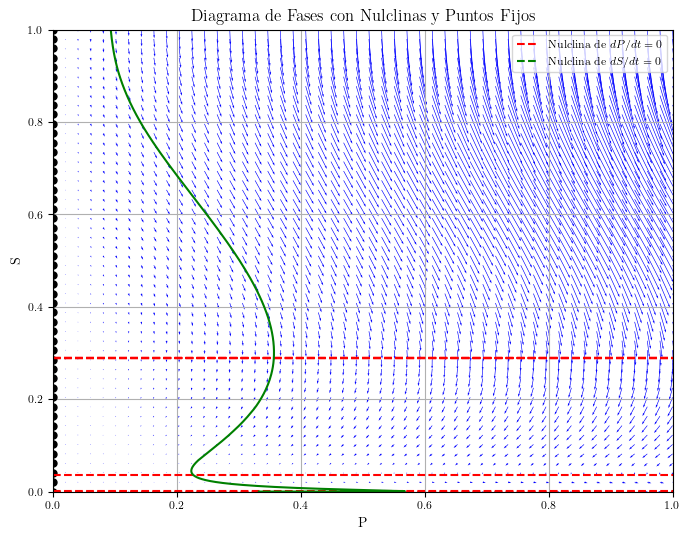

In [ ]:
# Graficar el diagrama de fases con nulclinas y puntos fijos
plt.figure(figsize=(8, 6))
# plt.quiver(P_grid, S_grid, dP_vals, dS_vals, color='blue', alpha=0.5,scale=1, width=0.005)
plt.quiver(P_grid, S_grid, dP_vals, dS_vals, color='blue',scale=500, width=0.001)


# Graficar las nulclinas (solo como ejemplo)
plt.axhline(0, color='r', linestyle='--', label='Nulclina de $dP/dt = 0$')
plt.axvline(0, color='g', linestyle='--', label='Nulclina de $dS/dt = 0$')

# Graficar los puntos fijos
for point in fixed_points:
    P_val, S_val = point
    plt.plot(P_val, S_val, 'ko', markersize=5)

for nulclina_P in S_roots:
    plt.axhline(nulclina_P, color='r', linestyle='--')


plt.plot(P_int, S_int, color='green')
plt.xlabel('P')
plt.ylabel('S')
plt.title('Diagrama de Fases con Nulclinas y Puntos Fijos')
plt.legend()
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.show()